# Demonstration of Metrics for Galactic Plane Science

Author: R.A. Street
With thanks to Lynne Jones and Peter Yoachim

This notebook is designed to demonstrate how to run the contributed MAF metrics for Galactic Plane science.  
We begin by importing the necessary libraries, including the MAF itself:

In [1]:
import os
from sys import argv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
import healpy as hp
from astropy import units as u
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy.io import fits
from rubin_sim.maf.metrics import galacticPlaneMetrics, galplaneTimeSamplingMetrics

### Configuration

In [2]:
# Defines the resolution of HEALpix sky map to be used throughout, and the corresponding number of HEALpixels
NSIDE = 64  
NPIX = hp.nside2npix(NSIDE) 

# Categories of variability defined according to the minimum interval between successive observations 
# (tau_obs) needed to detect them
tau_obs = np.array([2.0, 5.0, 11.0, 20.0, 46.5, 73.0])

Load the LSST Operations Simulation (OpSim) database to be analyzed.  
Many different realizations of the LSST survey strategy have been produced for comparison, and can be downloaded from:
http://astro-lsst-01.astro.washington.edu:8080/

In [3]:
# Can also be set to a string path to an alternative OpSim database file
opsim_db_path = get_baseline()
opsim_db = maf.OpsimDatabase(opsim_db_path)
runName = os.path.split(opsim_db_path)[-1].replace('.db', '')
print('Calculating galactic science metrics for LSST survey simulation: '+runName)

Calculating galactic science metrics for LSST survey simulation: baseline_v2.0_10yrs


### Selecting a science survey region map

The Galactic Science metrics includes a wide range of science.  The regions of the sky which each science case desires to survey have been combined into a single, combined_map, footprint, which is used below to calculate a summary metric for all Galactic Science.  However, the metric can also be run for any of the constituent maps, listed below, by following the same procedure, but selecting a different map in the next cell.  

In [5]:
available_science_maps = ['combined_map', 'galactic_plane_map', 'galactic_bulge_map', 'magellenic_clouds_map',
                'pencilbeams_map', 'open_clusters_map', 'globular_clusters_map', 'bonito_sfr_map',
                'zucker_sfr_map', 'clementini_stellarpops_map', 'xrb_priority_map']
mapName = available_science_maps[0]
print('Calculating the galactic science metrics for: '+mapName)

Calculating the galactic science metrics for: combined_map


### Calculating the metric for the loaded OpSim

The MAF provides a framework to enable multiple metrics to be calculated for the loaded OpSim database in a single run, by creating a list of the metrics we wish to include.  The list below includes the galactic science metrics for survey footprint and cadence.

In [13]:
bundleList = []
metric1 = galacticPlaneMetrics.GalPlaneFootprintMetric(science_map=mapName)
metric2 = galplaneTimeSamplingMetrics.GalPlaneVisitIntervalsTimescaleMetric(science_map=mapName)
metric3 = galplaneTimeSamplingMetrics.GalPlaneSeasonGapsTimescaleMetric(science_map=mapName)

Next we need to tell the MAF what spatial region of the sky we wish to calculate the metrics for, known as a slicer.  For almost all science metrics, we will use a HEALpix slicer, which will calculate the metric value for each HEALpixel in the whole sky.  

In [14]:
slicer = maf.slicers.HealpixSlicer(nside=NSIDE, useCache=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


The MAF also gives us the option to calculate the metric using a subset of the observations made during the survey.  In this example, we will select only observations for which the faintest object detected at 5$\sigma$ above the background reaches a deep limiting magnitude suitable for objects in the Galactic Plane. This constraint is optional, and the string can be left empty. 

In [15]:
constraint = 'fiveSigmaDepth > 21.5'

Once the metrics are calculated, the MAF can generate a set of informative summary plots automatically.  Here we configure the plotting range for these graphics (this is also optional).

In [16]:
plotDict = {'colorMax': 950}

With these components, we can add fully-specified metrics to the list to be calculated.  The MAF framework repackages the information above into the form necessary to calculate the data.  Lastly, the runAll method performs the calculations. 

In [17]:
bundleList.append(maf.MetricBundle(metric1, slicer, constraint, runName=runName, plotDict=plotDict))
bundleList.append(maf.MetricBundle(metric2, slicer, constraint, runName=runName, plotDict=plotDict))
bundleList.append(maf.MetricBundle(metric3, slicer, constraint, runName=runName, plotDict=plotDict))
bundleDict = maf.metricBundles.makeBundlesDictFromList(bundleList)
bundleGroup = maf.MetricBundleGroup(bundleDict, opsim_db, outDir='test', resultsDb=None)
bundleGroup.runAll()

Querying table None with constraint fiveSigmaDepth > 21.5 for columns ['fieldRA', 'fiveSigmaDepth', 'rotSkyPos', 'filter', 'observationStartMJD', 'fieldDec']
Found 2040356 visits
Running:  ['baseline_v2_0_10yrs_GalplaneFootprintMetric_combined_map_fiveSigmaDepth_gt_21_5_HEAL', 'baseline_v2_0_10yrs_GalPlaneVisitIntervalsTimescales_combined_map_fiveSigmaDepth_gt_21_5_HEAL', 'baseline_v2_0_10yrs_GalPlaneSeasonGapsTimescales_combined_map_fiveSigmaDepth_gt_21_5_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Evaluating the results

The MAF provides a suite of useful plotting routines that can be accessed through the plotAll method.  

The GalPlaneFootprintMetric produces metric values NObs: number of matching observations per HEALpixel with the desired survey footprint and NObsPriority: number of observations x priority of each HEALpixel in the desired survey footprint.  

It also calculates reduced metrics for each category of variability timescale.  For the footprint metric, the GalplaneFootprintMetric_<science_map>_ Tau _<tau_obs> output plots the survey HEALpixels that received at least the minimum number of observations to enable variables of the given timescale to be detected.  

The GalPlaneVisitIntervalsTimescales metric evaluates the intervals between observations of a given HEALpixel, using a decay function to downweight observations taken at intervals that exceed the timescale of each category of variability.  

The GalPlaneSeasonGapsTimescales metric is most applicable for longer-timescale variables only.  It can be neglected for shorter timescale categories of variability because some gaps between observing seasons are inevitable for most parts of the sky, and short-timescale phenomena will always be missed.  The metric is useful when comparing multi-year survey strategies where the entire sky is not always surveyed each year.  

/Users/rstreet1/software/rubin_sim/rubin_sim/maf/plots/plotHandler.py:584: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting figures with "fiveSigmaDepth > 21.5" constraint now.


/Users/rstreet1/software/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 241 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/rstreet1/software/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 214 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
/Users/rstreet1/software/rubin_sim/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/rstreet1/software/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
/Users/rstreet1/software/rubin_sim/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/rstreet1/software/r

Plotting complete.


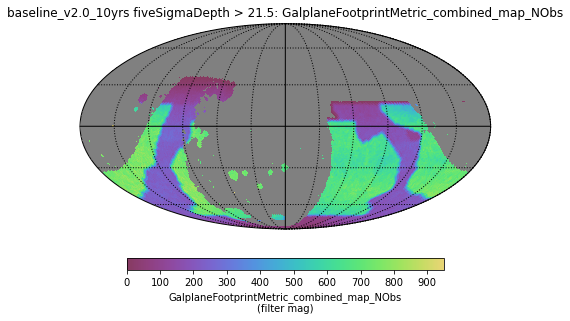

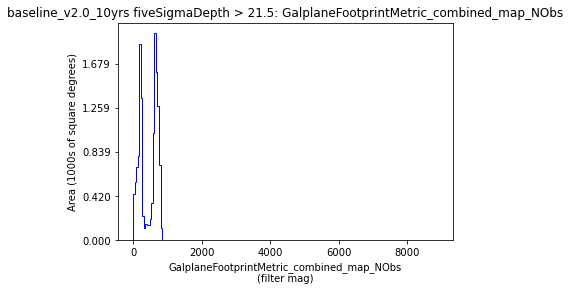

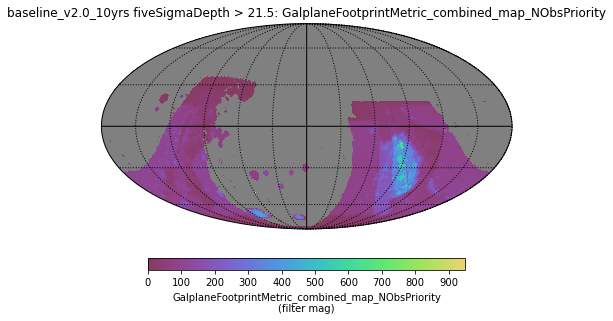

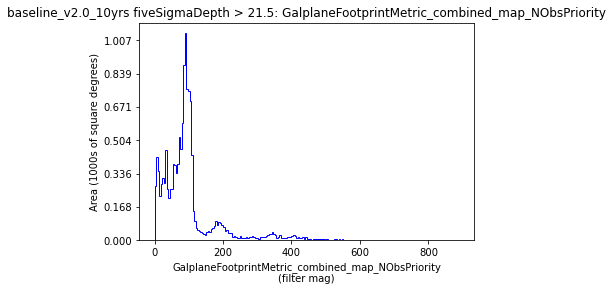

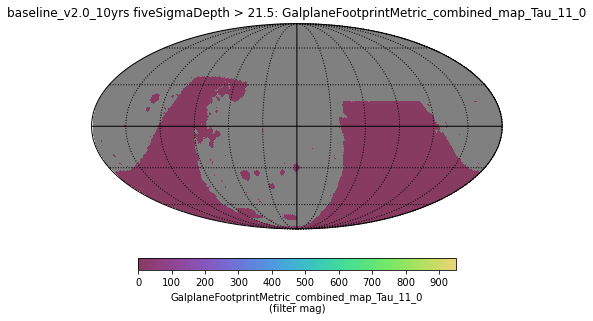

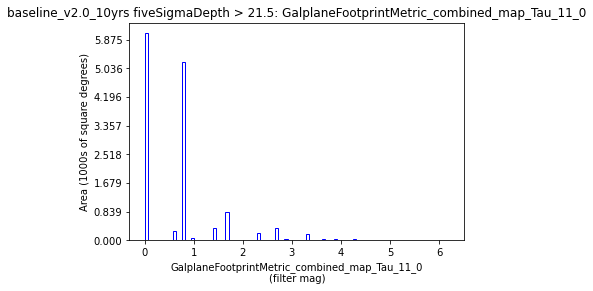

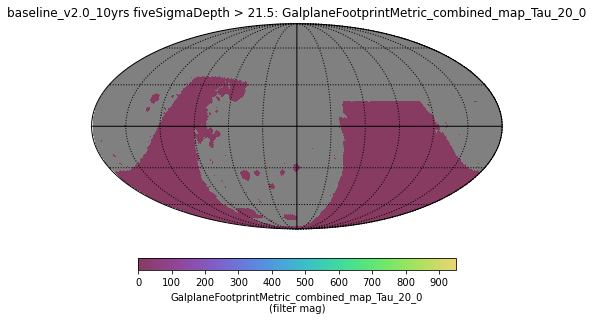

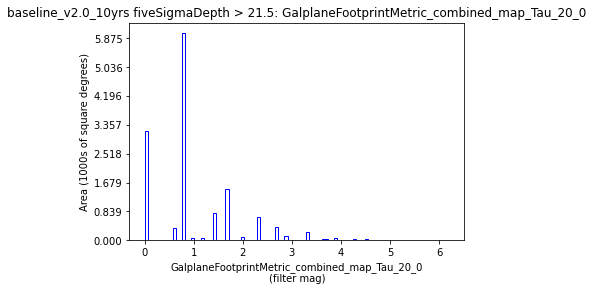

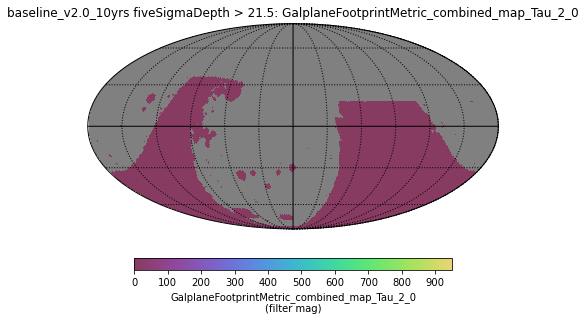

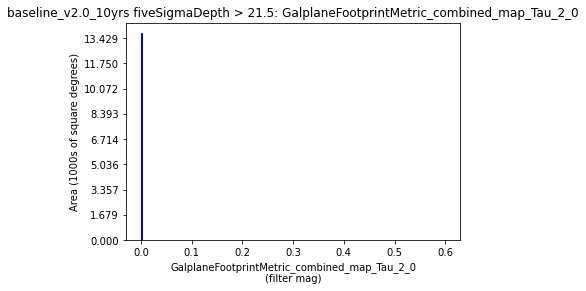

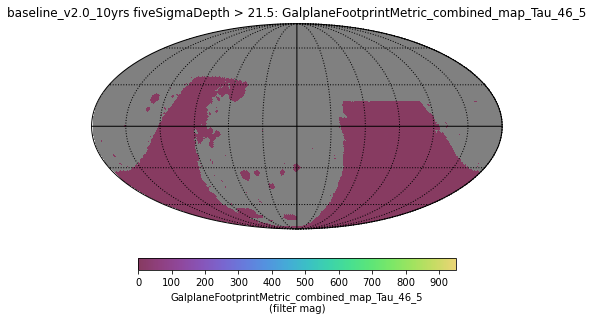

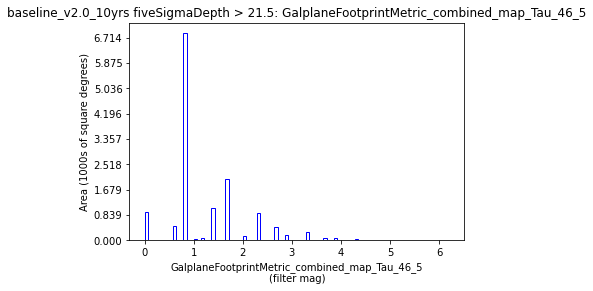

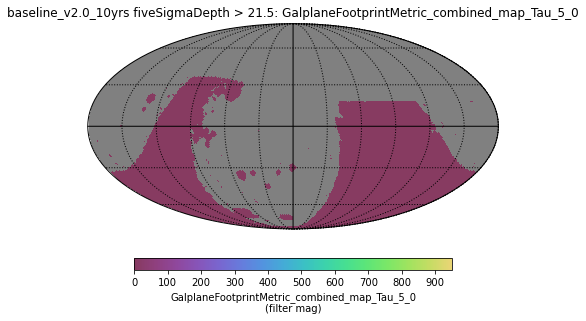

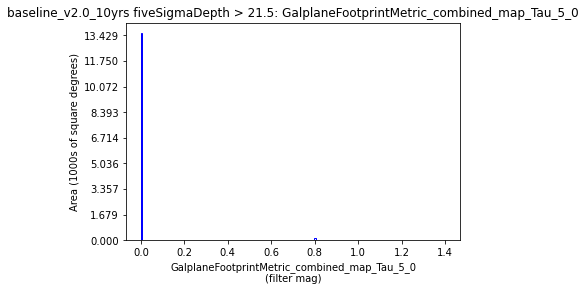

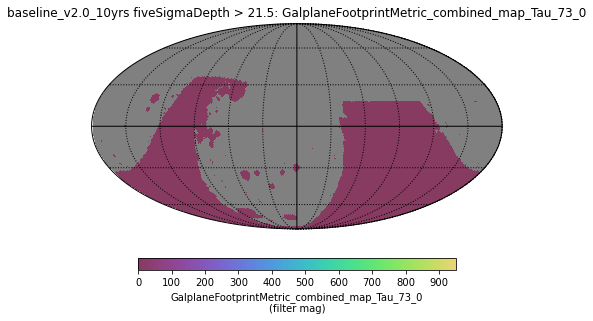

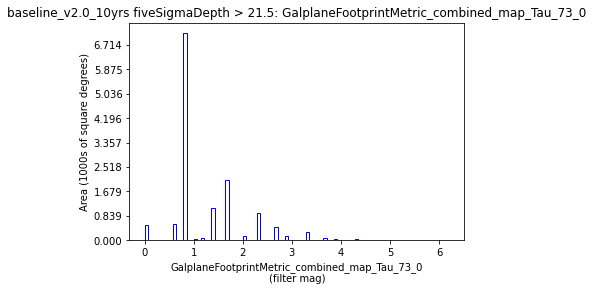

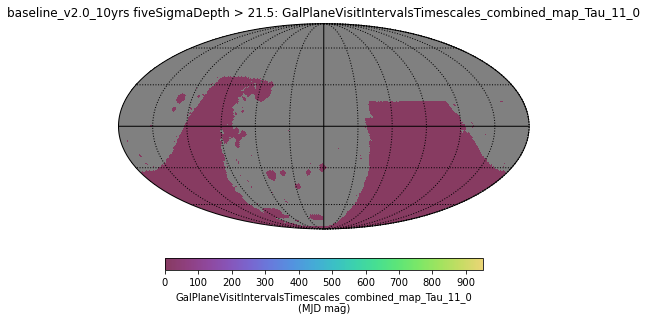

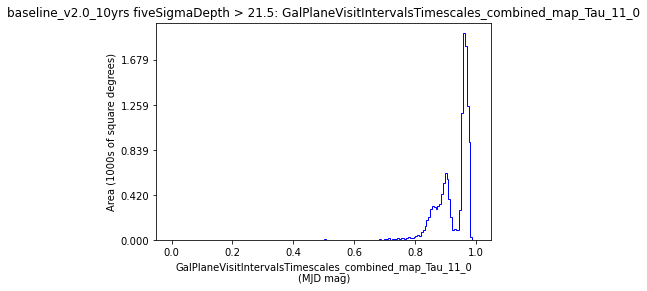

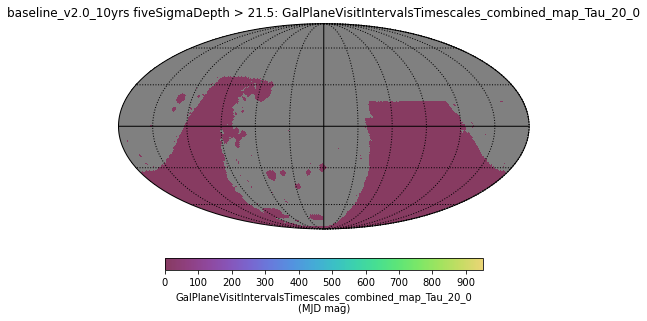

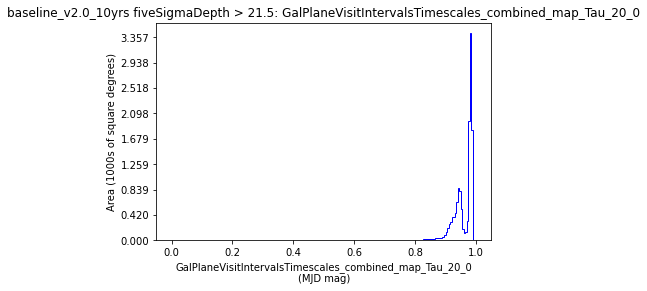

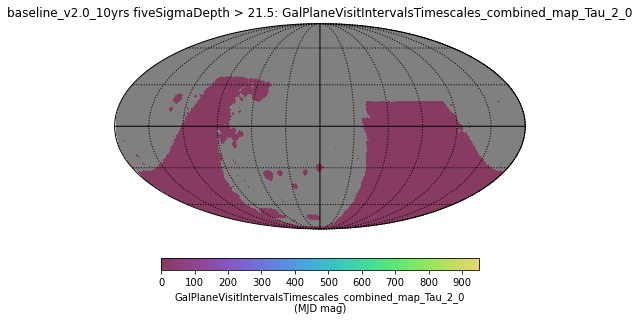

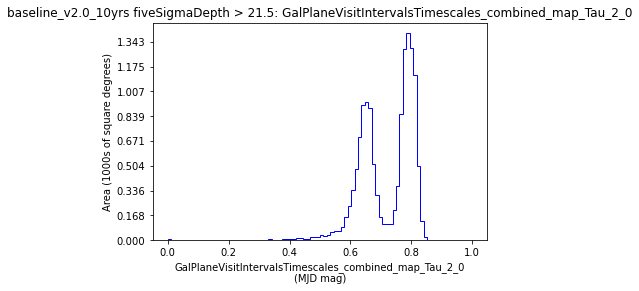

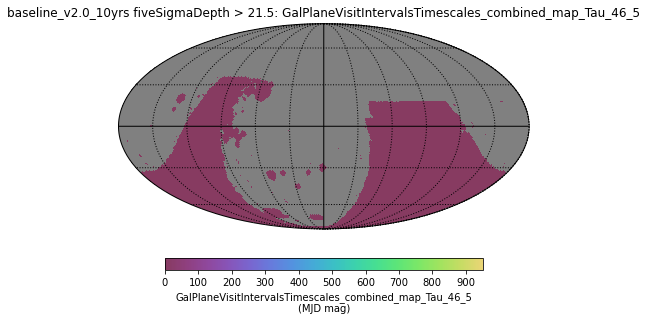

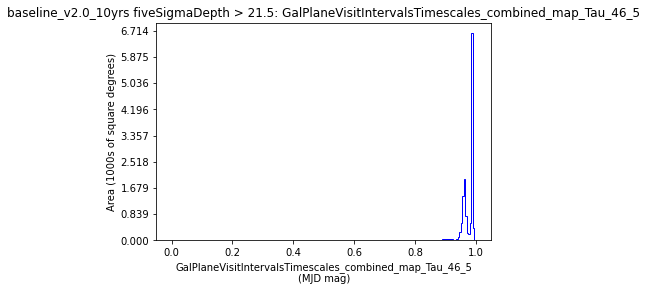

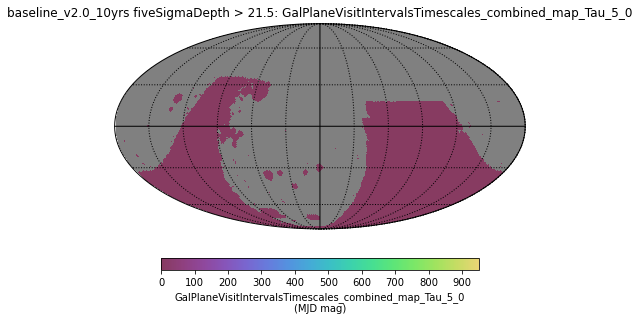

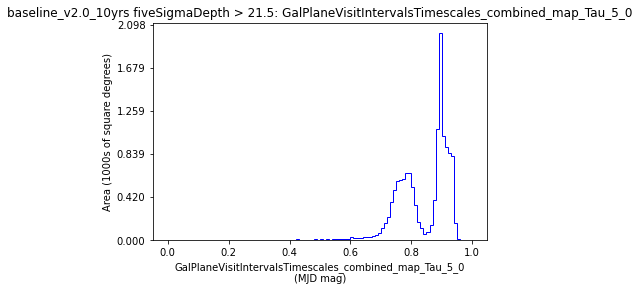

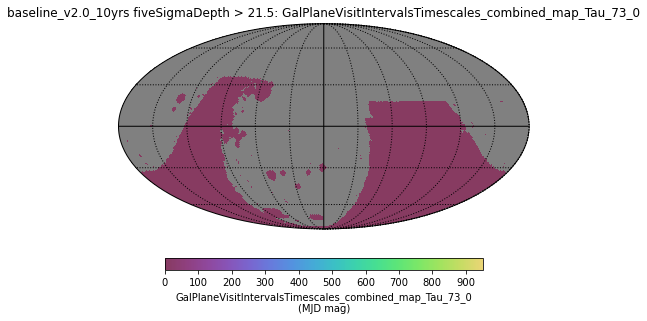

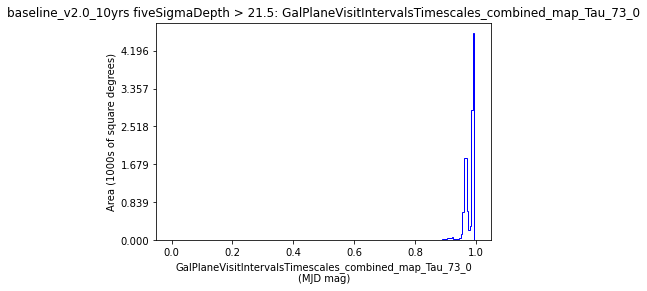

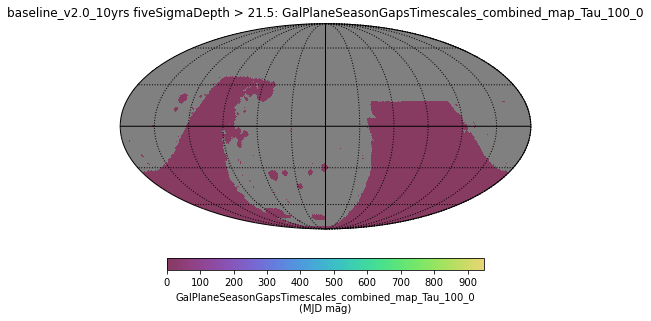

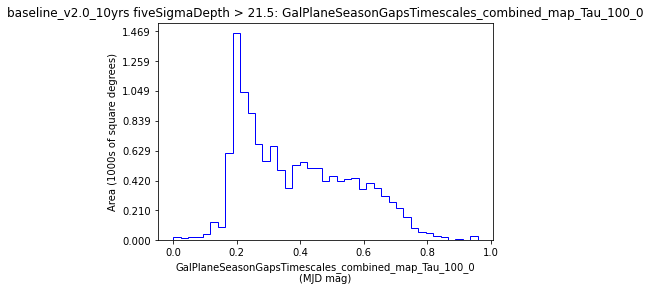

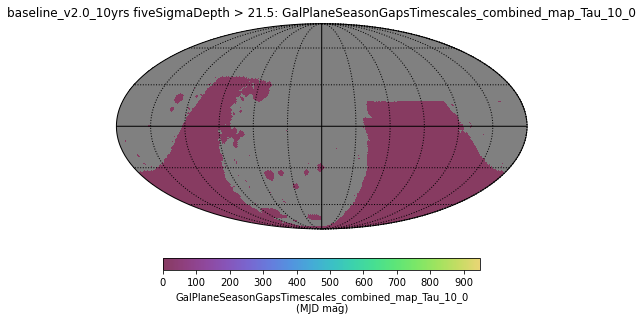

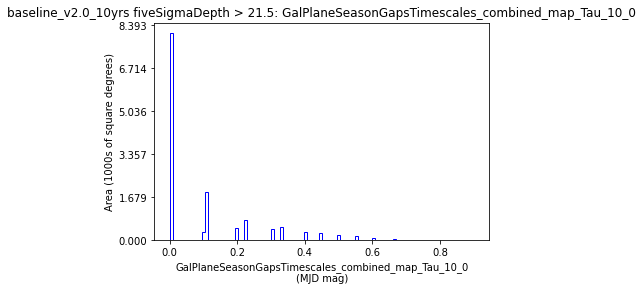

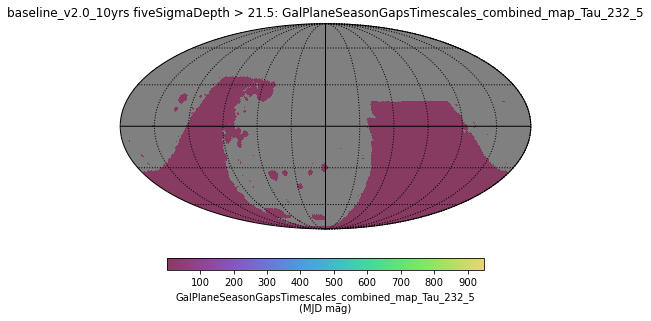

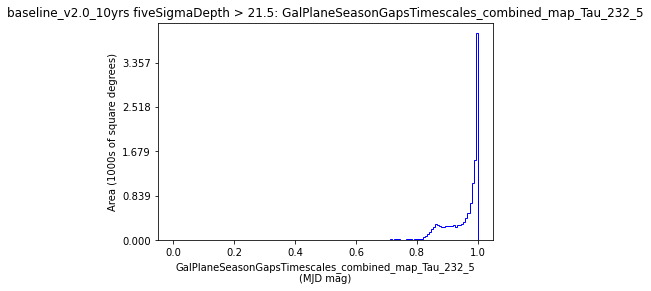

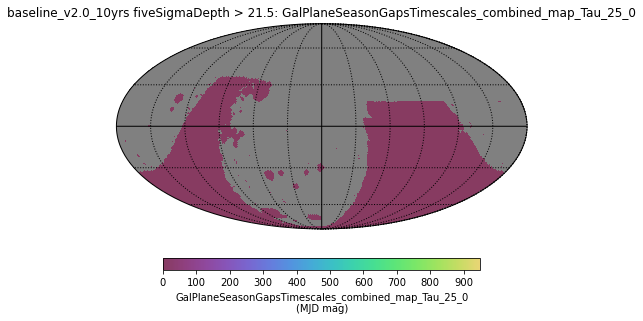

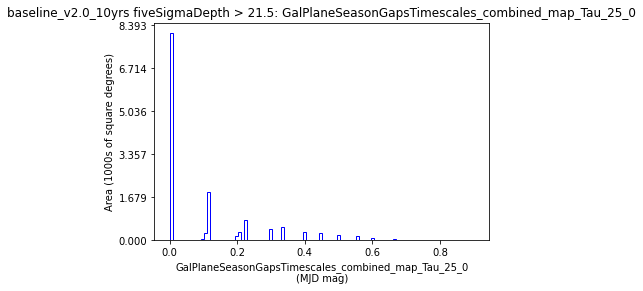

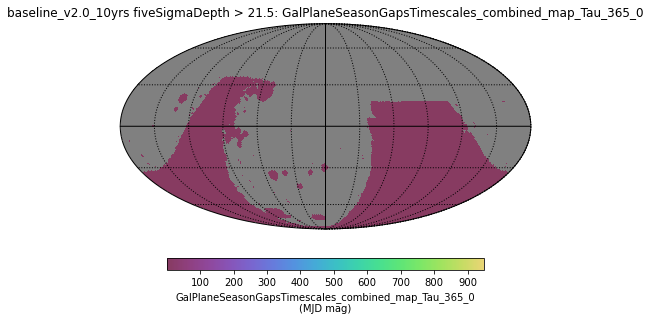

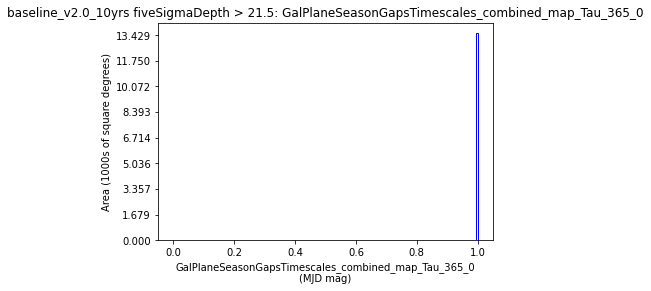

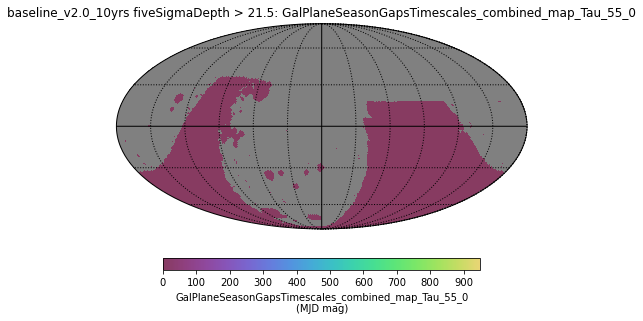

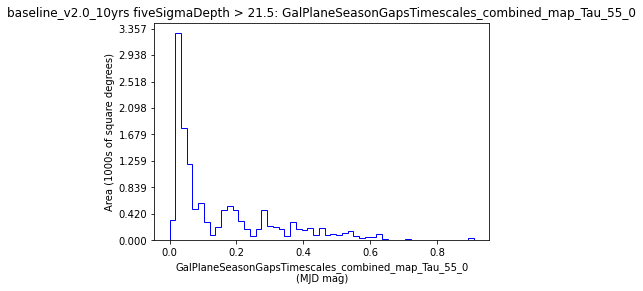

In [18]:
bundleGroup.plotAll(closefigs=False)

It is also useful to access the metric data values for each HEALpixel on the sky, which can be done from the bundleDict object produced above.  The keys of this Python dictionary describe the metric data held:

In [21]:
print('Each entry in this list refers to a metric calculated for each point on the sky: \n')
print(repr(bundleDict.keys()))

Each entry in this list refers to a metric calculated for each point on the sky: 

dict_keys(['baseline_v2_0_10yrs_GalplaneFootprintMetric_combined_map_fiveSigmaDepth_gt_21_5_HEAL', 'baseline_v2_0_10yrs_GalPlaneVisitIntervalsTimescales_combined_map_fiveSigmaDepth_gt_21_5_HEAL', 'baseline_v2_0_10yrs_GalPlaneSeasonGapsTimescales_combined_map_fiveSigmaDepth_gt_21_5_HEAL', 'GalplaneFootprintMetric_combined_map_NObs', 'GalplaneFootprintMetric_combined_map_NObsPriority', 'GalplaneFootprintMetric_combined_map_Tau_11_0', 'GalplaneFootprintMetric_combined_map_Tau_20_0', 'GalplaneFootprintMetric_combined_map_Tau_2_0', 'GalplaneFootprintMetric_combined_map_Tau_46_5', 'GalplaneFootprintMetric_combined_map_Tau_5_0', 'GalplaneFootprintMetric_combined_map_Tau_73_0', 'GalPlaneVisitIntervalsTimescales_combined_map_Tau_11_0', 'GalPlaneVisitIntervalsTimescales_combined_map_Tau_20_0', 'GalPlaneVisitIntervalsTimescales_combined_map_Tau_2_0', 'GalPlaneVisitIntervalsTimescales_combined_map_Tau_46_5', 'GalPla

By selecting any one of these keys, we can access the 1D array of corresponding metric values for each HEALpixel on the sky in RING HEALpixel order.  

IMPORTANT: Rubin cannot observe the entire sky, and null metric values are returned for HEALpixels outside the Rubin visibility zone.  Some data artefacts have been observed if calculations are made without filling these null values with zero, as performed by the line below.  Valid metric values for the rest of the sky remain unaffected.  

In [23]:
metric_output = 'GalPlaneVisitIntervalsTimescales_combined_map_Tau_46_5'
metricData = bundleDict[metric_output].metricValues.filled(0.0)

print('Values for all HEALpixels on the sky for metric '+metric_output+': \n')
print(metricData)

Values for all HEALpixels on the sky for metric GalPlaneVisitIntervalsTimescales_combined_map_Tau_46_5: 

[0.         0.         0.         ... 0.84413729 0.80793575 0.83029552]
